### Part 0: Preliminaries

In [1]:
import re
import pyspark

sc = pyspark.SparkContext(appName="App")

In [2]:
sc

<SparkContext master=local[*] appName=App>

In [3]:
DATAFILE_PATTERN = '^(.+),"(.+)",(.*),(.*),(.*)'

In [4]:
def removeQuotes(s):
    """ Remove quotation marks from an input string 
    Args:
        s (str): input string that might have the quote "" characters 
    Returns:
        str: a string without the quote characters 
    """
    return "".join(i for i in s if i != '"')

In [5]:
def parseDataFileLine(dataFileLine):
    """ Parse a line of the data file using the specified regular expression pattern 
    Args:
        datafileLine (str): input string that is a line from the data file 
    Returns:
        str: a string parsed using the given regular expression and without the quote characters 
    """
    match = re.search(DATAFILE_PATTERN, dataFileLine)
    if match is None:
        print('Invalid datafile line: %s' % dataFileLine)
        return (dataFileLine, -1) 
    elif match.group(1) == '"id"':
        print('Header datafile line: %s' % dataFileLine)
        return (dataFileLine, 0)
    else:
        product = '%s %s %s' % (match.group(2), match.group(3), match.group(4)) 
        return ((removeQuotes(match.group(1)), product), 1)

In [6]:
GOOGLE_PATH = './Assignment3DataSet/Google.csv'
GOOGLE_SMALL_PATH = './Assignment3DataSet/Google_small.csv'
AMAZON_PATH = './Assignment3DataSet/Amazon.csv'
AMAZON_SMALL_PATH = './Assignment3DataSet/Amazon_small.csv'
GOLD_STANDARD_PATH = './Assignment3DataSet/Amazon_Google_perfectMapping.csv'
STOPWORDS_PATH = './Assignment3DataSet/stopwords.txt'

def parseData(filename):
    """ Parse a data file 
    Args:
        filename (str): input file name of the data file 
    Returns:
        RDD: a RDD of parsed lines
    """
    return (sc.textFile(filename, 4, 1).map(parseDataFileLine))

def loadData(filename):
    """ Load a data file 
    Args:
        path (str): input file name of the data file 
    Returns:
        RDD: a RDD of parsed valid lines 
    """
    raw = parseData(filename).cache()
    failed = (raw.filter(lambda s: s[1] == -1).map(lambda s: s[0]))
    
    for line in failed.take(10):
        print('%s - Invalid datafile line: %s' % (filename, line))
    valid = (raw.filter(lambda s: s[1] == 1).map(lambda s: s[0]).cache())
    print('%s - Read %d lines, successfully parsed %d lines, failed to parse %d lines' 
          % (filename, raw.count(),valid.count(), failed.count()))
    
    assert failed.count() == 0
    assert raw.count() == (valid.count() + 1) 
   
    return valid


In [7]:
googleSmall = loadData(GOOGLE_SMALL_PATH)
google = loadData(GOOGLE_PATH)
amazonSmall = loadData(AMAZON_SMALL_PATH)
amazon = loadData(AMAZON_PATH)

./Assignment3DataSet/Google_small.csv - Read 201 lines, successfully parsed 200 lines, failed to parse 0 lines
./Assignment3DataSet/Google.csv - Read 3227 lines, successfully parsed 3226 lines, failed to parse 0 lines
./Assignment3DataSet/Amazon_small.csv - Read 201 lines, successfully parsed 200 lines, failed to parse 0 lines
./Assignment3DataSet/Amazon.csv - Read 1364 lines, successfully parsed 1363 lines, failed to parse 0 lines


In [8]:
for line in googleSmall.take(3):
    print('google: %s: %s\n' % (line[0], line[1]))

google: http://www.google.com/base/feeds/snippets/11448761432933644608: spanish vocabulary builder "expand your vocabulary! contains fun lessons that both teach and entertain you'll quickly find yourself mastering new terms. includes games and more!" 

google: http://www.google.com/base/feeds/snippets/8175198959985911471: topics presents: museums of world "5 cd-rom set. step behind the velvet rope to examine some of the most treasured collections of antiquities art and inventions. includes the following the louvre - virtual visit 25 rooms in full screen interactive video detailed map of the louvre ..." 

google: http://www.google.com/base/feeds/snippets/18445827127704822533: sierrahome hse hallmark card studio special edition win 98 me 2000 xp "hallmark card studio special edition (win 98 me 2000 xp)" "sierrahome"



In [9]:
for line in amazonSmall.take(3):
    print('amazon: %s: %s\n' % (line[0], line[1]))

amazon: b000jz4hqo: clickart 950 000 - premier image pack (dvd-rom)  "broderbund"

amazon: b0006zf55o: ca international - arcserve lap/desktop oem 30pk "oem arcserve backup v11.1 win 30u for laptops and desktops" "computer associates"

amazon: b00004tkvy: noah's ark activity center (jewel case ages 3-8)  "victory multimedia"



## Part 1: ER as Text Similarity - Bags of Words

### (1a) Tokenizing a string

In [10]:
quickbrownfox = 'A quick brown fox jumps over the lazy dog.'
split_regex = r'\W+'

In [11]:
def simpleTokenize(string):
    """ A simple implementation of input string tokenization 
    Args:
        string (str): input string 
    Returns:
        list: a list of tokens 
    """
    tokenList = re.split(split_regex, string.lower())
    tokenList = [token for token in tokenList if token != '']
    return tokenList

In [12]:
print(simpleTokenize(quickbrownfox))
print(simpleTokenize(' '))
print(simpleTokenize('!!!!123A/456_B/789C.123A'))
print(simpleTokenize('fox fox'))

['a', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
[]
['123a', '456_b', '789c', '123a']
['fox', 'fox']


### (1b) Removing stopwords

In [13]:
stopfile = STOPWORDS_PATH
stopwords = set(sc.textFile(stopfile).collect())

In [14]:
print('These are the stopwords: %s' % stopwords)

These are the stopwords: {'who', 'i', 'off', 'at', 's', 'further', 'over', 'him', 'for', 'am', 'on', 'until', 'of', 'just', 'own', 'myself', 'into', 'theirs', 'no', 'having', 'hers', 'to', 'while', 'been', 'our', 'yourselves', 'an', 'why', 'so', 'only', 'about', 'have', 'most', 'then', 'yourself', 'those', 'whom', 'which', 'be', 'she', 'will', 'from', 'both', 'all', 'his', 'each', 'same', 'because', 'has', 'doing', 'them', 'out', 'their', 'my', 'the', 'not', 't', 'themselves', 'as', 'under', 'very', 'or', 'this', 'such', 'than', 'between', 'does', 'any', 'herself', 'were', 'up', 'during', 'that', 'and', 'nor', 'other', 'did', 'but', 'itself', 'if', 'had', 'me', 'how', 'where', 'was', 'these', 'being', 'do', 'yours', 'ourselves', 'above', 'too', 'should', 'ours', 'few', 'after', 'he', 'some', 'with', 'what', 'can', 'now', 'you', 'are', 'your', 'is', 'in', 'her', 'don', 'its', 'it', 'below', 'here', 'once', 'through', 'down', 'when', 'again', 'by', 'before', 'against', 'himself', 'we', '

In [15]:
def tokenize(string):
    """ An implementation of input string tokenization that excludes stopwords 
    Args:
        string (str): input string 
    Returns:
        list: a list of tokens without stopwords 
    """
    tokenList = re.split(split_regex, string.lower())
    tokenList = [token for token in tokenList if token != '' and token not in stopwords]
    return tokenList

In [16]:
print(tokenize(quickbrownfox))
print(tokenize("Why a the?"))
print(tokenize("Being at the_?"))

['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog']
[]
['the_']


### (1b) Tokenizing the small Datasets

In [17]:
amazonRecToToken = amazonSmall.map(lambda rec: (rec[0], tokenize(rec[1])))
googleRecToToken = googleSmall.map(lambda rec: (rec[0], tokenize(rec[1])))

In [18]:
def countTokens(vendorRDD):
    return vendorRDD.flatMap(lambda rec: rec[1]).count()

In [19]:
totalTokens = countTokens(amazonRecToToken) + countTokens(googleRecToToken) 
print('There are %s tokens in the combined datasets' % totalTokens)

There are 22520 tokens in the combined datasets


In [20]:
total = amazonSmall.flatMap(lambda rec: tokenize(rec[1])).collect() + googleSmall.flatMap(lambda rec: tokenize(rec[1])).collect()
print('There are %s tokens in the combined datasets' % totalTokens)

There are 22520 tokens in the combined datasets


### (1d Amazon record with most tokens

In [21]:
def findBiggestRecord(vendorRDD):
    return vendorRDD.map(lambda rec: (rec[0], len(rec[1]))).takeOrdered(1, lambda rec: -1 * rec[1])


In [22]:
biggestRecordAmazon = findBiggestRecord(amazonRecToToken)
print('The Amazon record with ID "%s" has the most tokens (%s)' % (biggestRecordAmazon[0][0],
biggestRecordAmazon[0][1]))

The Amazon record with ID "b000o24l3q" has the most tokens (1547)


# Part 2: ER as Text Similarity - Weighted Bag-of-Words using TF-IDF

### (2a) Implement a TF Function

In [23]:
def tf(tokens):
    
    termFrequencyDict = {}
    lengthOfTokensList = len(tokens)
    
    for token in tokens:
        if token in termFrequencyDict:
            termFrequencyDict[token] += (1.0/lengthOfTokensList)
        else:
            termFrequencyDict[token] = (1.0/lengthOfTokensList)
    
    return termFrequencyDict

In [24]:
print(tf(tokenize(quickbrownfox)))

{'quick': 0.16666666666666666, 'brown': 0.16666666666666666, 'fox': 0.16666666666666666, 'jumps': 0.16666666666666666, 'lazy': 0.16666666666666666, 'dog': 0.16666666666666666}


In [25]:
print(tf(tokenize('one_ one_ two!')))

{'one_': 0.6666666666666666, 'two': 0.3333333333333333}


### (2b) Create a Corpus

In [26]:
corpusRDD = googleRecToToken.union(amazonRecToToken)

In [27]:
corpusRDD.count()

400

### (2c) Implement an IDFs Function

In [28]:
def idfs(corpus):
    """ Compute IDF 
    Args:
        corpus (RDD): input corpus 
    Returns:
        RDD: a RDD of (token, IDF value) 
    """
    N = corpus.count()
    uniqueTokens = corpus.map(lambda rec: set(rec[1]))
    tokenCountPairTuple = uniqueTokens.flatMap(lambda rec: [(r, 1) for r in rec])
    tokenSumPairTuple = tokenCountPairTuple.reduceByKey(lambda a, b: a+b)
    
    return tokenSumPairTuple.map(lambda rec: (rec[0], N/rec[1]))

In [29]:
idfsSmall = idfs(amazonRecToToken.union(googleRecToToken)) 
uniqueTokenCount = idfsSmall.count()
print('There are %s unique tokens in the small datasets.' % uniqueTokenCount)

There are 4772 unique tokens in the small datasets.


In [30]:
tokenSmallestIdf = idfsSmall.takeOrdered(1, lambda s: s[1])[0]
print(tokenSmallestIdf[0])

software


In [31]:
print(abs(tokenSmallestIdf[1] - 4.25531914894) < 0.0000000001)

True


### (2d) Tokens with the Smallest IDF

In [32]:
smallIDFTokens = idfsSmall.takeOrdered(11, lambda s: s[1])
print(smallIDFTokens)

[('software', 4.25531914893617), ('features', 6.896551724137931), ('new', 6.896551724137931), ('use', 7.017543859649122), ('complete', 7.2727272727272725), ('easy', 7.6923076923076925), ('cd', 8.333333333333334), ('create', 8.333333333333334), ('system', 8.333333333333334), ('windows', 8.51063829787234), ('1', 8.51063829787234)]


### (2e) IDF Histogram

In [33]:
import matplotlib.pyplot as plt

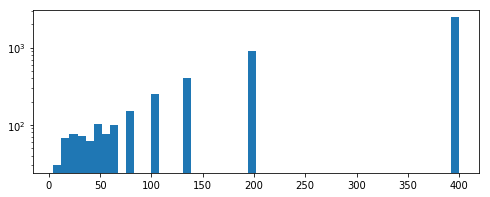

In [34]:
small_idf_values = idfsSmall.map(lambda s: s[1]).collect()
plt.figure(figsize=(8,3))
plt.hist(small_idf_values, 50, log = True)
plt.show()

In [35]:
from pyspark.sql import Row, SQLContext

In [36]:
sqlContext = SQLContext(sc)

In [37]:
idfsToCountRow = idfsSmall.map(lambda x: Row(token=x[0], value=x[1]))
idfsToCountDF = sqlContext.createDataFrame(idfsToCountRow)
display(idfsToCountDF)
pd = idfsToCountDF.toPandas()

DataFrame[token: string, value: double]

In [38]:
pd.head()

,token,value
0,950,400.000000
1,rom,16.666667
2,dvd,16.000000
3,v11,400.000000
4,ca,57.142857


### (2f) Implement a TF-IDF Function

In [39]:
def tfidf(tokens, idfs): 
    """ Compute TF-IDF 
    Args:
        tokens (list of str): input list of tokens from tokenize 
        idfs (dictionary): record to IDF value 
    Returns:
        dictionary: a dictionary of records to TF-IDF values 
    """
    tfs = tf(tokens)
    tfIdfDict = {(token , tfs[token]*idfs[token]) for token in set(tokens)}
    return dict(tfIdfDict)

In [40]:
recb000hkgj8k = amazonRecToToken.filter(lambda x: x[0] == 'b000hkgj8k').collect()[0][1] 
idfsSmallWeights = idfsSmall.collectAsMap()
rec_b000hkgj8k_weights = tfidf(recb000hkgj8k, idfsSmallWeights)
print('Amazon record "b000hkgj8k" has tokens and weights:\n%s' % rec_b000hkgj8k_weights)

Amazon record "b000hkgj8k" has tokens and weights:
{'customizing': 16.666666666666664, 'psg': 33.33333333333333, 'autocad': 33.33333333333333, '2007': 3.5087719298245617, 'courseware': 66.66666666666666, 'autodesk': 8.333333333333332, 'interface': 3.0303030303030303}


# Part 3: ER as Text Similarity - Cosine Similarity

### (3a) Implement the Components of a cosineSimilarity Function

In [41]:
import math

In [42]:
def dotprod(a, b):
    """ Compute dot product
    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value 
    Returns:
        dotProd: result of the dot product with the two input dictionaries 
    """
    return sum(a[tok] * b[tok] for tok in a.keys() if tok in b.keys())

In [43]:
def norm(a):
    """ Compute square root of the dot product 
    Args:
        a (dictionary): a dictionary of record to value 
    Returns:
        norm (float): the square root of the dot product value 
    """
    return math.sqrt(dotprod(a,a))

In [44]:
def cossim(a, b):
    """ Compute cosine similarity Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value 
    Returns:
        cossim: dot product of two dictionaries divided by the norm of the first dictionary and then by the norm of the second dictionary
    """
    return (dotprod(a,b) / norm(a)) / norm(b)

In [80]:
testVec1 = {'foo': 2, 'bar': 3, 'baz': 5 } 
testVec2 = {'foo': 1, 'bar': 0, 'baz': 20 }
dp = dotprod(testVec1, testVec2)
nm = norm(testVec1)
print(dp, nm)
print(cossim(testVec1, testVec2))

102 6.164414002968976
0.8262970212292282


### (3b) Implement a cosineSimilarity Function

In [46]:
def cosineSimilarity(string1, string2, idfsDictionary): 
    """ Compute cosine similarity between two strings 
    Args:
        string1 (str): first string
        string2 (str): second string
    idfsDictionary (dictionary): a dictionary of IDF values
    Returns:
        cossim: cosine similarity value
    """
    w1 = tfidf(tokenize(string1), idfsDictionary) 
    w2 = tfidf(tokenize(string2), idfsDictionary)
    return cossim(w1, w2)

In [47]:
cossimAdobe = cosineSimilarity('Adobe Photoshop', 'Adobe Illustrator',idfsSmallWeights)

In [48]:
cossimAdobe

0.057724338216303385

### (3c) Perform Entity Resolution

In [49]:
crossSmall = googleSmall.cartesian(amazonSmall).cache()

In [50]:
def computeSimilarity(record):
    """ Compute similarity on a combination record 
    Args:
        record: a pair, (google record, amazon record) 
    Returns:
        3-tuple: (google URL, amazon ID, cosine similarity value) 
    """
    googleRec = record[0]
    amazonRec = record[1]
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue, amazonValue, idfsSmallWeights) 
    return (googleURL, amazonID, cs)

In [51]:
similarities = (crossSmall.map(computeSimilarity).cache())

In [52]:
def similar(amazonID, googleURL): 
    """ Return similarity value
    Args:
        amazonID: amazon ID
        googleURL: google URL 
    Returns:
        similar: cosine similarity value 
    """
    return similarities.filter(lambda record: (record[0] == googleURL and record[1] == amazonID)).collect()[0][2]


In [53]:
similarityAmazonGoogle = similar('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print('Requested similarity is %s.' % similarityAmazonGoogle)


Requested similarity is 0.0003031719404513201.


### (3d) Perform Entity Resolution with Broadcast Variables

In [82]:
def computeSimilarityBroadcast(record):
    """ Compute similarity on a combination record, using Broadcast variable 
    Args:
        record: a pair, (google record, amazon record) 
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value) 
    """
    googleRec = record[0]
    amazonRec = record[1]
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue, amazonValue, idfsSmallBroadcast.value)
    return (googleURL, amazonID, cs)
 
weights = idfsSmallWeights.copy()
idfsSmallBroadcast = sc.broadcast(weights) 
similaritiesBroadcast = (crossSmall.map(computeSimilarityBroadcast).cache())
    
    
def similarBroadcast(amazonID, googleURL):
    """ Return similarity value, computed using Broadcast variable 
    Args:
        amazonID: amazon ID
        googleURL: google URL Returns:
    similar: cosine similarity value 
    """
    return (similaritiesBroadcast.filter(lambda record: (record[0] == googleURL and record[1] == amazonID)) .collect()[0][2])

similarityAmazonGoogleBroadcast = similarBroadcast('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print('Requested similarity is %s.' % similarityAmazonGoogleBroadcast)
print(len(idfsSmallBroadcast.value))


Requested similarity is 0.0003031719404513201.
4772


### (3e) Perform a Gold Standard Evaluation

In [55]:
GOLDFILE_PATTERN = '^(.+),(.+)'

In [56]:
def parse_goldfile_line(goldfile_line):
    """ Parse a line from the 'golden standard' data file
    Args:
        goldfile_line: a line of data
    Returns:
        pair: ((key, 'gold', 1 if successful or else 0))
    """
    match = re.search(GOLDFILE_PATTERN, goldfile_line)
    if match is None:
        print('Invalid goldfile line: %s' % goldfile_line)
        return (goldfile_line, -1)
    elif match.group(1) == '"idAmazon"':
        print('Header datafile line: %s' % goldfile_line)
        return (goldfile_line, 0)
    else:
        key = '%s %s' % (removeQuotes(match.group(1)), removeQuotes(match.group(2))) 
    return ((key, 'gold'), 1)

In [57]:
goldfile = GOLD_STANDARD_PATH 
gsRaw = (sc.textFile(goldfile).map(parse_goldfile_line).cache())
gsFailed = (gsRaw.filter(lambda s: s[1] == -1).map(lambda s: s[0]))
for line in gsFailed.take(10):
    print('Invalid goldfile line: %s' % line)
goldStandard = (gsRaw .filter(lambda s: s[1] == 1).map(lambda s: s[0]) .cache())
print('Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (gsRaw.count(), goldStandard.count(), 
                                                                                     gsFailed.count()))

assert (gsFailed.count() == 0)
assert (gsRaw.count() == (goldStandard.count() + 1))

Read 1301 lines, successfully parsed 1300 lines, failed to parse 0 lines


### Using the “gold standard” data we can answer the following questions:

In [58]:
sims = similaritiesBroadcast.map(lambda rec: (rec[1]+" "+rec[0], rec[2]))

In [59]:
sims.take(1)

[('b000jz4hqo http://www.google.com/base/feeds/snippets/11448761432933644608',
  0.0)]

In [60]:
goldStandard.take(1)

[('b000jz4hqo http://www.google.com/base/feeds/snippets/18441480711193821750',
  'gold')]

In [61]:
trueDupsRDD = sims.join(goldStandard)

In [62]:
trueDupsRDD.take(2)

[('b00066dd5m http://www.google.com/base/feeds/snippets/949436197920820923',
  (0.07847275689637273, 'gold')),
 ('b0002bqrq8 http://www.google.com/base/feeds/snippets/18386073325514862606',
  (0.14431063919825257, 'gold'))]

In [63]:
count = trueDupsRDD.count()

In [64]:
sumValue = trueDupsRDD.map(lambda rec: rec[1][0]).reduce(lambda a, b: a+b)

In [65]:
avgSimsDup = float(sumValue / count)
avgSimsDup

0.26433257343519145

In [66]:
nonDupsRDD = sims.leftOuterJoin(goldStandard).filter(lambda rec: rec[1][1] == None).map(lambda rec: (rec[0], rec[1][0]))

In [67]:
nonDupsRDD.take(5)

[('b00021xhzw http://www.google.com/base/feeds/snippets/18445827127704822533',
  0.0),
 ('b000gzwjgc http://www.google.com/base/feeds/snippets/8175198959985911471',
  0.0),
 ('b000aazr5i http://www.google.com/base/feeds/snippets/8175198959985911471',
  0.0),
 ('b0009rgzgm http://www.google.com/base/feeds/snippets/8175198959985911471',
  0.001603895822502505),
 ('b00006hvvo http://www.google.com/base/feeds/snippets/18445827127704822533',
  0.00021888375577371882)]

In [68]:
avgSimsNon = nonDupsRDD.map(lambda rec: rec[1]).sum()/float(nonDupsRDD.count())

In [69]:
print('There are %s true duplicates.' % count)
print('The average similarity of true duplicates is %s.' % avgSimsDup)
print('And for non duplicates, it is %s.' % avgSimsNon)

There are 146 true duplicates.
The average similarity of true duplicates is 0.26433257343519145.
And for non duplicates, it is 0.0012347630465555242.


# Assignment 4 - Continued

### (4a) Tokenize the full dataset

In [70]:
amazonFullRecToToken = amazon.map(lambda rec: (rec[0], tokenize(rec[1])))
googleFullRecToToken = google.map(lambda rec: (rec[0], tokenize(rec[1])))
print('Amazon full dataset is %s products, Google full dataset is %s products' % (amazonFullRecToToken.count(), googleFullRecToToken.count()))

Amazon full dataset is 1363 products, Google full dataset is 3226 products


### (4b) Compute IDFs and TF-IDFs for the full datasets

In [71]:
fullCorpusRDD = amazonFullRecToToken.union(googleFullRecToToken)
idfsFull = idfs(fullCorpusRDD)
idfsFullCount = idfsFull.count()
print('There are %s unique tokens in the full datasets.' % idfsFullCount)

There are 17078 unique tokens in the full datasets.


In [72]:
idfsFullWeights = idfsFull.collectAsMap()
idfsFullBroadcast = sc.broadcast(idfsFullWeights)

In [73]:
amazonWeightsRDD = amazonFullRecToToken.map(lambda x: (x[0], tfidf(x[1],idfsFullBroadcast.value)))
googleWeightsRDD = googleFullRecToToken.map(lambda x: (x[0], tfidf(x[1],idfsFullBroadcast.value)))
print('There are %s Amazon weights and %s Google weights.' % (amazonWeightsRDD.count(), googleWeightsRDD.count()))

There are 1363 Amazon weights and 3226 Google weights.


### (4c) Compute Norms for the weights from the full datasets

In [74]:
amazonNorms = amazonWeightsRDD.map(lambda x: (x[0], norm(x[1])))
amazonNormsBroadcast = sc.broadcast(amazonNorms.collectAsMap())
googleNorms = googleWeightsRDD.map(lambda x: (x[0], norm(x[1])))
googleNormsBroadcast = sc.broadcast(googleNorms.collectAsMap())

In [75]:
print(len(amazonNormsBroadcast.value))
print(len(googleNormsBroadcast.value))

1363
3226


### (4d) Create inverted indicies from the full datasets

In [76]:
# TODO: Replace <FILL IN> with appropriate code
def invert(record):
    """ Invert (ID, tokens) to a list of (token, ID)
    Args:
        record: a pair, (ID, token vector)
    Returns:
        pairs: a list of pairs of token to ID
    """
    pairs = [(token, record[0]) for token in record[1]]
    return pairs

print(invert((1, {'foo': 2})))

[('foo', 1)]


In [77]:
amazonInvPairsRDD = (amazonWeightsRDD.flatMap(invert).cache())
googleInvPairsRDD = (googleWeightsRDD.flatMap(invert).cache())

print('There are %s Amazon inverted pairs and %s Google inverted pairs.' % (amazonInvPairsRDD.count(),
                                                                            googleInvPairsRDD.count()))

There are 111387 Amazon inverted pairs and 77678 Google inverted pairs.


### (4e) Identify common tokens from the full dataset

In [78]:
def swap(record):
    """ Swap (token, (ID, URL)) to ((ID, URL), token)
    Args:
        record: a pair, (token, (ID, URL))
    Returns:
        pair: ((ID, URL), token)
    """
    token = record[0]
    keys = record[1]
    return (keys, token)

In [79]:
commonTokens = (amazonInvPairsRDD.join(googleInvPairsRDD).map(swap).groupByKey().cache())
print('Found %d common tokens' % commonTokens.count())

KeyboardInterrupt: 

### (4f) Identify common tokens from the full dataset (cont.)

In [ ]:
amazonWeightsBroadcast = sc.broadcast(amazonWeightsRDD.collectAsMap())
googleWeightsBroadcast = sc.broadcast(googleWeightsRDD.collectAsMap())

In [ ]:
def fastCosineSimilarity(record):
    """ Compute Cosine Similarity using Broadcast variables
    Args:
        record: ((ID, URL), token)
    Returns:
        pair: ((ID, URL), cosine similarity value)
    """
    amazonRec = record[0][0]
    googleRec = record[0][1]
    tokens = record[1]
    s = sum(amazonWeightsBroadcast.value[amazonRec][i] * googleWeightsBroadcast.value[googleRec][i] for i in tokens)
    value = s/(amazonNormsBroadcast.value[amazonRec] * googleNormsBroadcast.value[googleRec])
    key = (amazonRec, googleRec)
    return (key, value)

In [ ]:
similaritiesFullRDD = (commonTokens.map(fastCosineSimilarity).cache())
print(similaritiesFullRDD.count())

In [ ]:
similarityTest = similaritiesFullRDD.filter(lambda x: x[0][0] == 'b00005lzly' and x[0][1] == 'http://www.google.com/base/feeds/snippets/13823221823254120257').collect()
print(similarityTest)

# Part 5: Analysis

### (5a) Counting True Positives, False Positives, and False Negatives

In [ ]:
simsFullRDD = similaritiesFullRDD.map(lambda x: ("%s %s" % (x[0][0], x[0][1]), x[1]))
assert (simsFullRDD.count() == 2441100)

In [ ]:
simsFullValuesRDD = (simsFullRDD
                     .map(lambda x: x[1])
                     .cache())
assert (simsFullValuesRDD.count() == 2441100)

In [ ]:
def gs_value(record):
    if (record[1][1] is None):
        return 0
    else:
        return record[1][1]

In [ ]:
trueDupSimsRDD = (goldStandard.leftOuterJoin(simsFullRDD).map(gs_value).cache())
print('There are %s true duplicates.' % trueDupSimsRDD.count())
assert(trueDupSimsRDD.count() == 1300)

### (5b) Precision, Recall, and F-measures

In [ ]:
from pyspark.accumulators import AccumulatorParam
class VectorAccumulatorParam(AccumulatorParam):
    # Initialize the VectorAccumulator to 0
    def zero(self, value):
        return [0] * len(value)

    # Add two VectorAccumulator variables
    def addInPlace(self, val1, val2):
        for i in range(len(val1)):
            val1[i] += val2[i]
        return val1

In [ ]:
# Return a list with entry x set to value and all other entries set to 0
def set_bit(x, value, length):
    bits = []
    for y in range(length):
        if (x == y):
            bits.append(value)
        else:
            bits.append(0)
    return bits

In [ ]:
# Pre-bin counts of false positives for different threshold ranges
BINS = 101
nthresholds = 100
def bin(similarity):
    return int(similarity * nthresholds)

# fpCounts[i] = number of entries (possible false positives) where bin(similarity) == i
zeros = [0] * BINS
fpCounts = sc.accumulator(zeros, VectorAccumulatorParam())

def add_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, 1, BINS)

simsFullValuesRDD.foreach(add_element)

# Remove true positives from FP counts
def sub_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, -1, BINS)

trueDupSimsRDD.foreach(sub_element)

def falsepos(threshold):
    fpList = fpCounts.value
    return sum([fpList[b] for b in range(0, BINS) if float(b) / nthresholds >= threshold])

def falseneg(threshold):
    return trueDupSimsRDD.filter(lambda x: x < threshold).count()

def truepos(threshold):
    return trueDupSimsRDD.count() - falsenegDict[threshold]

In [ ]:
def precision(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falseposDict[threshold])

def recall(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falsenegDict[threshold])

def fmeasure(threshold):
    r = recall(threshold)
    p = precision(threshold)
    return 2 * r * p / (r + p)

### (5c) Line Plots

In [ ]:
thresholds = [float(n) / nthresholds for n in range(0, nthresholds)]
falseposDict = dict([(t, falsepos(t)) for t in thresholds])
falsenegDict = dict([(t, falseneg(t)) for t in thresholds])
trueposDict = dict([(t, truepos(t)) for t in thresholds])

precisions = [precision(t) for t in thresholds]
recalls = [recall(t) for t in thresholds]
fmeasures = [fmeasure(t) for t in thresholds]

print(precisions[0], fmeasures[0])
assert (abs(precisions[0] - 0.000532546802671) < 0.0000001)
assert (abs(fmeasures[0] - 0.00106452669505) < 0.0000001)


fig = plt.figure()
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, fmeasures)
plt.legend(['Precision', 'Recall', 'F-measure'])

In [ ]:
graph = [(t, precision(t), recall(t),fmeasure(t)) for t in thresholds]
graphRDD = sc.parallelize(graph)

graphRow = graphRDD.map(lambda txyz: Row(threshold=txyz[0], precision=txyz[1], recall=txyz[2], fmeasure=txyz[3]))
graphDF = sqlContext.createDataFrame(graphRow)
graphDF.columns

In [ ]:
graphDF.show(10)

### (5d) Discussion